# Bar Code Detector
This is the python code to detect barcodes, as of right now it only detects the barcode, (and possibly large boxes of text).

#### Papers
https://pdfs.semanticscholar.org/625d/d30503d2909fbfe0dfa806c9322b3571190a.pdf 


## Utilities

In [1]:
import numpy as np
from numpy import linalg
from skimage import io, filters, feature, morphology, measure
from skimage.color import rgb2gray
import skimage.transform as skt
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import os
F = False
T = True
from IPython.display import clear_output

### getImageArray
Gets all the images in a folder and converts them to grayscale

In [2]:
#Function to get all images in a folder
def getImageArray(folder):  
   
    files = os.listdir(folder)
    images = []
    
    # since files will not be in the order I want it in I will set the images to the rigt position
    for f in files:
        tmp = rgb2gray(io.imread(folder + "\\" + f))
        #print(f," : ",tmp.shape)
        images.append(tmp)
        
    return images

### printImg
Shows all the images in an array

In [3]:
def printImg(imgs):
    j = 1
    for i in imgs:
        plt.imshow(i,cmap='gray')
        plt.axis("off")
        p = "Image " + str(j)
        plt.title(p)
        plt.show()
        j += 1

### bringOut
This will "bring out" the barcodes after the filter and thresholding, this is done by eroding the smaller white spots away then, dilate them afterwards.

In [4]:
def bringOut(img, iter = 1):
    
    erode = morphology.binary_erosion(img)
    
    for j in range(iter - 1):
        erode = morphology.erosion(erode)
        
    dil = morphology.binary_dilation(erode)
    
    for j in range(iter - 1):
        dil = morphology.dilation(dil)
        
    return dil

### fft
This will filter the image using the kernel in the frquency domain.

In [5]:
def fft(image, kernel):
    imgR, imgC = image.shape[:2]
    kernR, kernC = kernel.shape[:2]
    
    kernPad = np.zeros(image.shape[:2])
    
    sR = (imgR - kernR) // 2
    sC = (imgC - kernC) // 2
    
    kernPad[sR : sR + kernR, sC : sC + kernC] = kernel    

    imgFFT = np.fft.fft2(image)
    kernFFT = np.fft.fft2(kernPad)

    filt = np.fft.fftshift(np.fft.ifft2(imgFFT * kernFFT)) 

    return filt / np.max(filt)

### getGauss
This will get a gaussian kernel for use in filtering.

In [6]:
def getGauss(width,height,sigma):
    tmp = signal.get_window(('gaussian', sigma),width)
    tmp2 = signal.get_window(('gaussian', sigma),height)
    gauss = np.outer(tmp,tmp2)
    
    return gauss

### highPass
This will do a highpass filtering using the fft.

In [7]:
def highPass(img, kernel):
    filt = img/np.max(img) - fft(img,kernel)
    return filt

## Images
I pulled all these images from Google, I wanted to get some variety in the images so I can test if i can get a transform invarient method of detecting barcodes. Images 1, 2, and 5 I expect to give me problems since the barcode is partially covered (image 5) or there is other stuff in the image that could be taken as barcodes like text or in image 1 the nutrition facts.

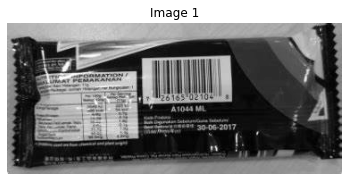

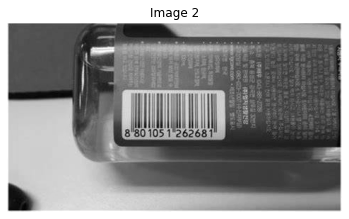

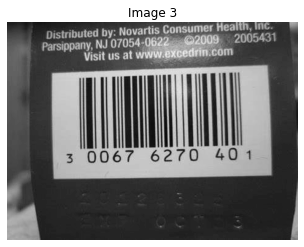

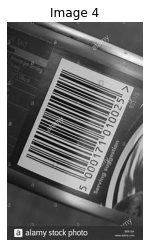

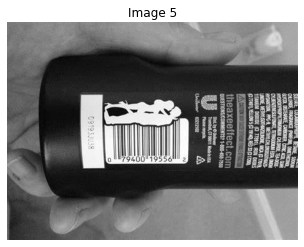

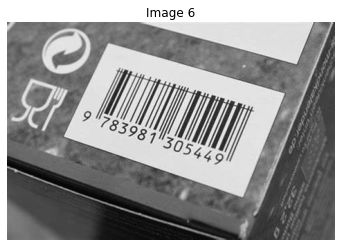

In [8]:
imgs = getImageArray("Data\\Barcodes\\")
printImg(imgs)

# Edge Detection
First I wanted to try some edge detecting filters since barcodes are just lines, since I have varied images and they are not perfect I need to use an edge detector that will work with both horizontal and vertical edges or a mixture of both.

## Sobel
I started off with a sobel filter for no particular reason other than its an option.\
My process:
1. Sobel Filter the image
2. Gaussian Blur
3. Threshold the image to make it binary
4. Erode and Dilate the image to "bring out" areas where there are many edges
5. Find the contours of the parts of the image from the previous section
6. Display

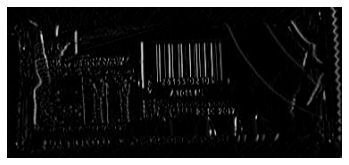

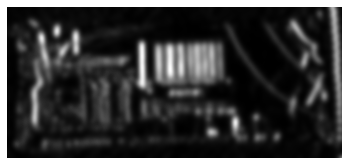

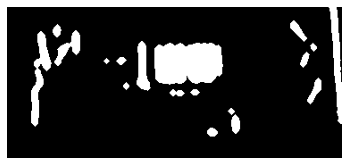

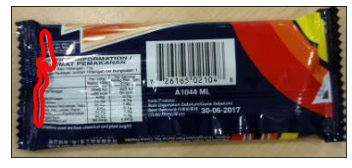

In [9]:
#Image 1
grad = filters.sobel_v(imgs[0])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,3)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

dil = bringOut(tmp1, 3)

plt.imshow(dil,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(dil, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\1.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

The poor images need much more tweaks to get to work but I can get them to work. In this one I cheated a little and only used the vertical edges.

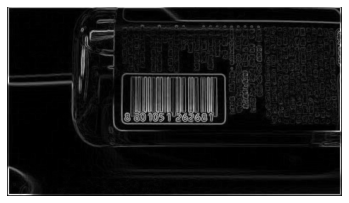

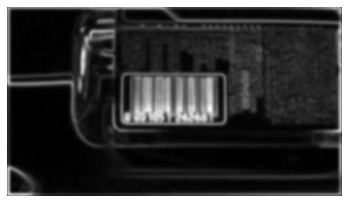

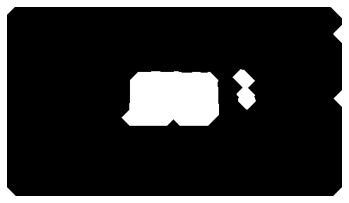

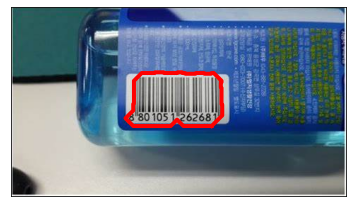

In [10]:
#Image 2
grad = filters.sobel(imgs[1])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,2)

fig, ax = filters.try_all_threshold(gauss)
fig.show()
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()




tmp = filters.threshold_li(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

dil = bringOut(tmp1, 11)

plt.imshow(dil,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(dil, .999)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\2.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c
        
for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

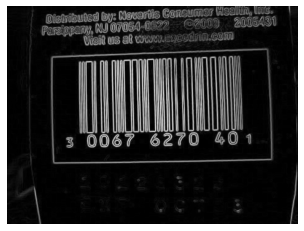

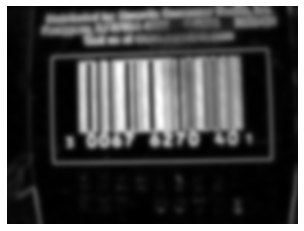

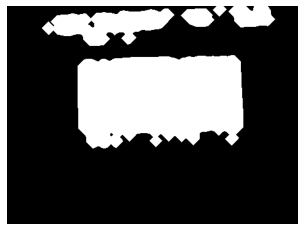

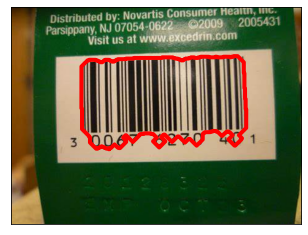

In [11]:
#Image 3
grad = filters.sobel(imgs[2])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,4)

fig, ax = filters.try_all_threshold(gauss)
fig.show()
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()

tmp = filters.threshold_isodata(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

dil = bringOut(tmp1, 10)

plt.imshow(dil,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(dil, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\3.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c
        
for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

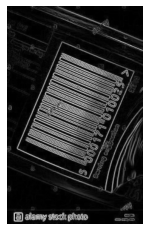

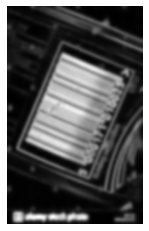

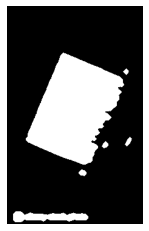

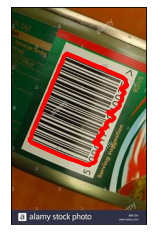

In [12]:
#Image 4
grad = filters.sobel(imgs[3])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,2.5)

fig, ax = filters.try_all_threshold(gauss)
fig.show()
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()

tmp = filters.threshold_isodata(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

dil = bringOut(tmp1, 3)

plt.imshow(dil,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(dil, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\4.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c
        
for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

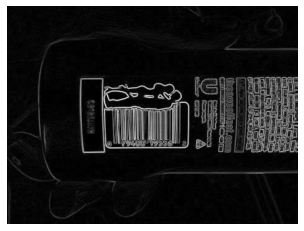

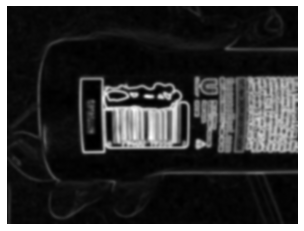

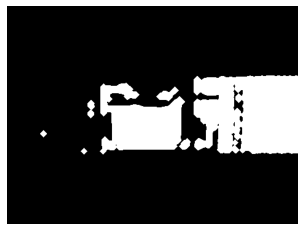

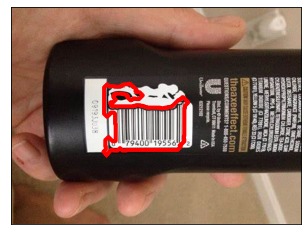

In [13]:
#Image 5
grad = filters.sobel(imgs[4])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,2)

fig, ax = filters.try_all_threshold(gauss)
fig.show()
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()

tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

dil = bringOut(tmp1, 5)

plt.imshow(dil,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(dil, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\5.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c
        
for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

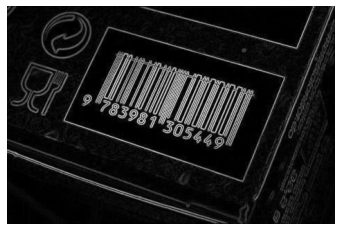

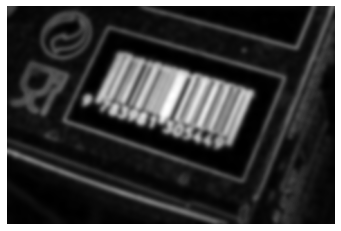

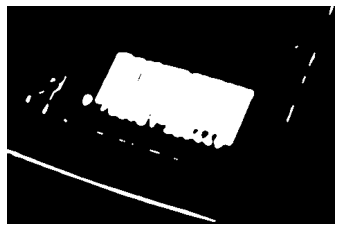

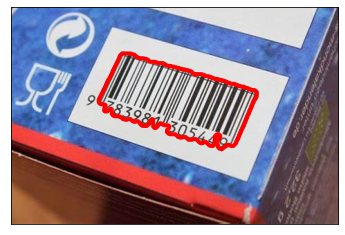

In [14]:
#Image 6
grad = filters.sobel(imgs[5])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,3)

fig, ax = filters.try_all_threshold(gauss)
fig.show()
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()

tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

dil = bringOut(tmp1, 1)

plt.imshow(dil,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(dil, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\6.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c
        
for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Some problems I came across was how I decided which contour region was the barcode, I simply used the largest region, I could improve this by checking the region and choosing the most rectangular.


## Laplace 
1. Laplace Filter the image
2. Gaussian Blur
3. Threshold the image to make it binary
4. Find the contours of the parts of the image from the previous section
5. Display


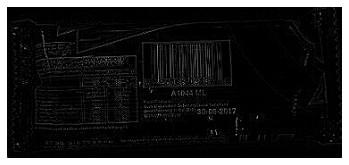

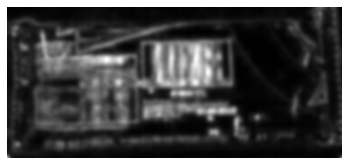

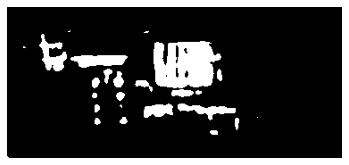

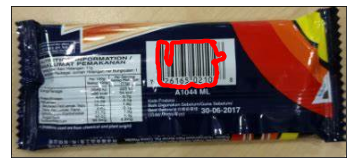

In [15]:
#Image 1
grad = filters.laplace(imgs[0])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,2.5)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()

tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\1.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

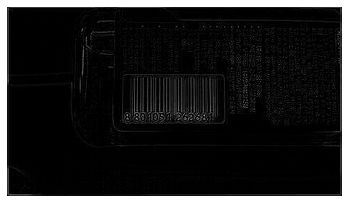

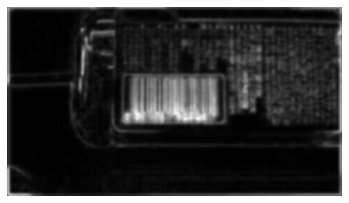

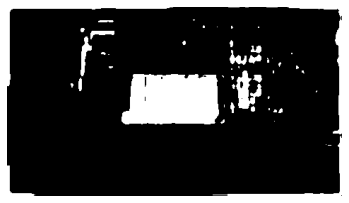

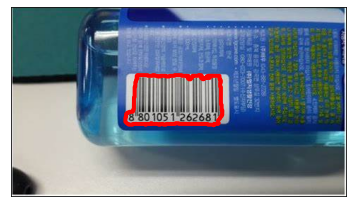

In [16]:
#Image 2
grad = filters.laplace(imgs[1])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,2)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\2.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

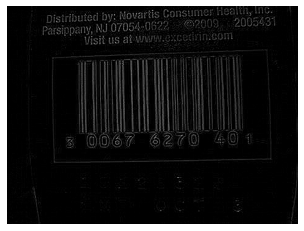

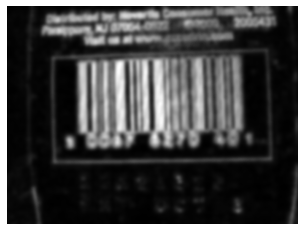

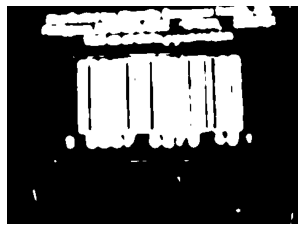

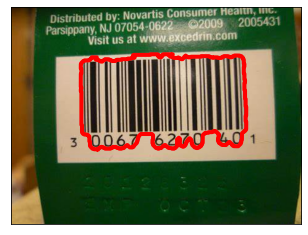

In [17]:
#Image 3
grad = filters.laplace(imgs[2])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,3)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\3.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

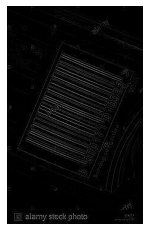

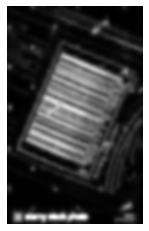

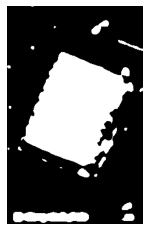

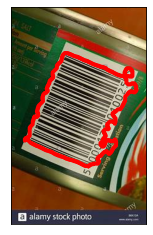

In [18]:
#Image 4
grad = filters.laplace(imgs[3])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,3)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\4.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

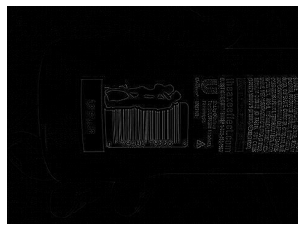

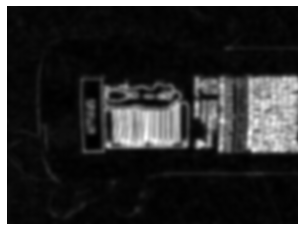

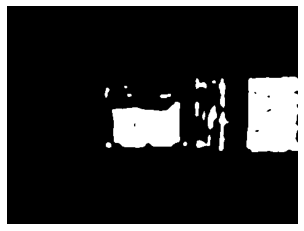

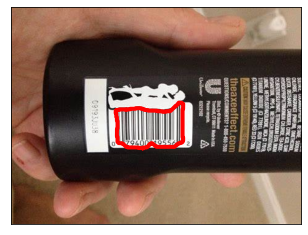

In [19]:
#Image 5
grad = filters.laplace(imgs[4])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,3)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_minimum(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\5.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

This one sadly will get the text even if I do the "get rectangular contour" but I do have the barcode as an option to choose, maybe having a tempalte filter after this might help.

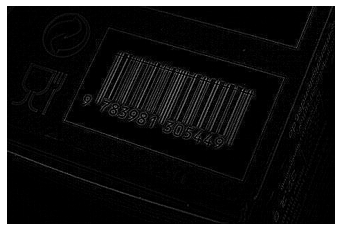

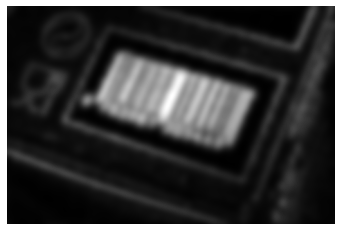

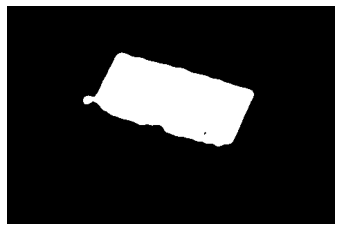

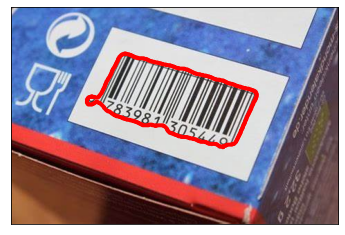

In [20]:
#Image 6
grad = filters.laplace(imgs[5])

tmp = grad < 0

grad[tmp] = 0

gauss = filters.gaussian(grad,5)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(grad,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_minimum(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\6.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# FFT
Since barcodes would have high frequency I wanted to see how well an FFT.
Process:\
1. FFT the image
2. High pass filter
3. Blur
5. Get contours
6. Display

This is mostly just the same as the above just another method so I will only do some images.

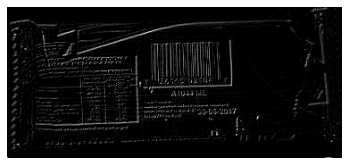

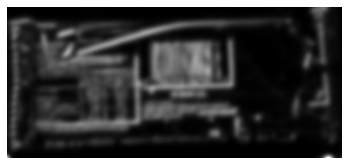

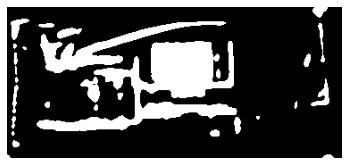

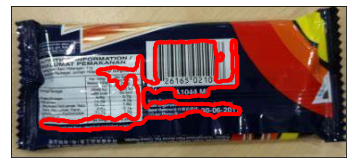

In [21]:
#Image 1
kern = getGauss(75,75,.5)

filt = np.real(highPass(imgs[0],kern))

tmp = filt < 0

filt[tmp] = 0

gauss = filters.gaussian(filt,3)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(filt,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\1.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

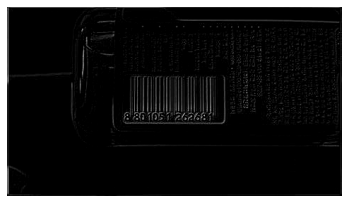

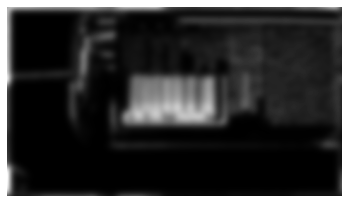

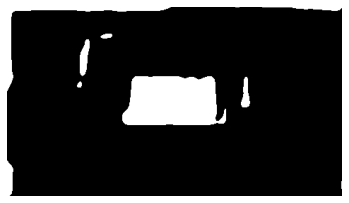

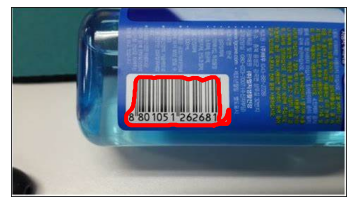

In [22]:
#Image 2
kern = getGauss(75,75,1)

filt = np.real(highPass(imgs[1],kern))

tmp = filt < 0

filt[tmp] = 0

gauss = filters.gaussian(filt,5)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(filt,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_otsu(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\2.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

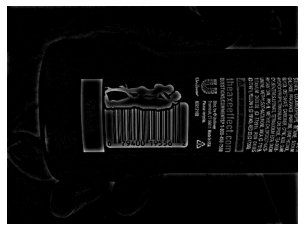

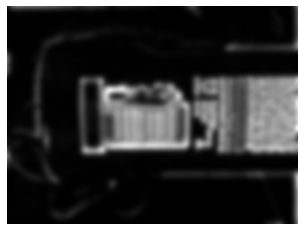

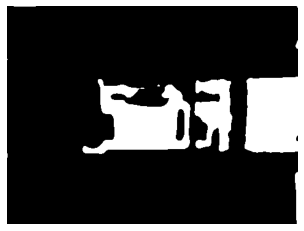

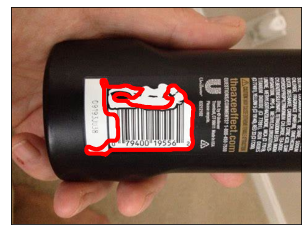

In [23]:
#Image 5
kern = getGauss(75,75,4)

filt = np.real(highPass(imgs[4],kern))

tmp = filt < 0

filt[tmp] = 0

gauss = filters.gaussian(filt,5)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(filt,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_minimum(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\5.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

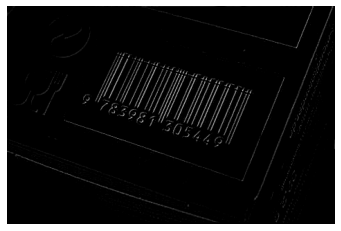

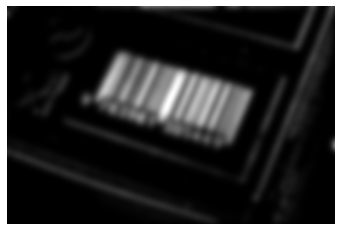

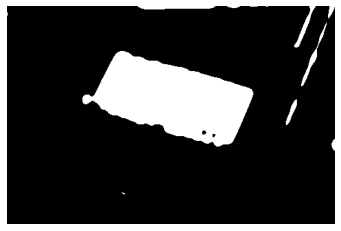

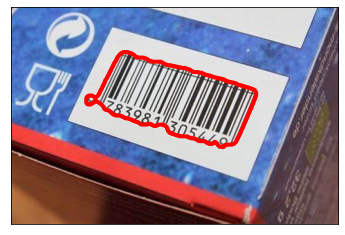

In [24]:
#Image 6
kern = getGauss(75,75,1)

filt = np.real(highPass(imgs[5],kern))

tmp = filt < 0

filt[tmp] = 0

gauss = filters.gaussian(filt,5)

fig, ax = filters.try_all_threshold(gauss)

fig.show()
plt.axis("off")
plt.show()

clear_output()

plt.imshow(filt,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(gauss,cmap='gray')
plt.axis("off")
plt.show()


tmp = filters.threshold_yen(gauss)

tmp1 = gauss
th = gauss >= tmp

tmp1[th] = 1

th = gauss < tmp

tmp1[th] = 0

plt.imshow(tmp1,cmap='gray')
plt.axis("off")
plt.show()

cont = measure.find_contours(tmp1, .9)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(io.imread("Data\\Barcodes\\6.jpg"))

cont = np.array(cont)

max = 0
ind = 0

for c in range(len(cont)):
    if cont[c].shape[0] > max:
        max = cont[c].shape[0]
        ind = c

for n, cont in enumerate(cont):
    if n == ind:
        ax.plot(cont[:, 1], cont[:, 0], linewidth=4, color = 'r')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Hough Transform
Here I follow the paper to see how I do.

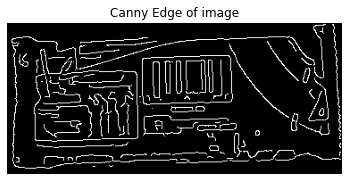

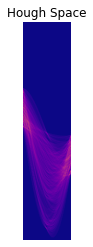

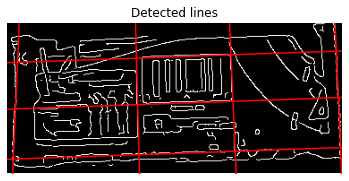

In [25]:
#Image 1
image = imgs[0]

edge = feature.canny(image,sigma=2)
plt.imshow(edge,cmap='gray')
plt.title("Canny Edge of image")
plt.axis("off")
plt.show()

h, theta, d = skt.hough_line(edge)
plt.title("Hough Space")
plt.axis("off")
plt.imshow(h,cmap='plasma')
plt.show()

plt.imshow(edge, cmap='gray')
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*skt.hough_line_peaks(h, theta, d,min_distance=50,min_angle=60)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title('Detected lines')
plt.show()

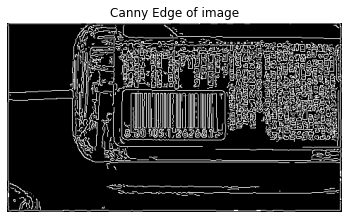

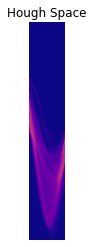

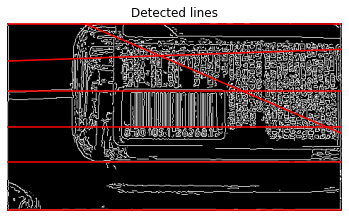

In [26]:
#Image 2
image = imgs[1]

edge = feature.canny(image,sigma=.001)

plt.imshow(edge,cmap='gray')
plt.title("Canny Edge of image")
plt.axis("off")
plt.show()

h, theta, d = skt.hough_line(edge)
plt.title("Hough Space")
plt.axis("off")
plt.imshow(h,cmap='plasma')
plt.show()

plt.imshow(edge, cmap='gray')
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*skt.hough_line_peaks(h, theta, d,min_distance=35,min_angle=60)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title('Detected lines')
plt.show()

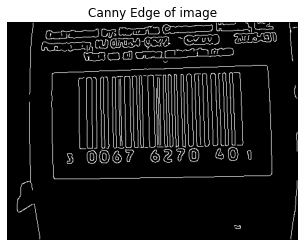

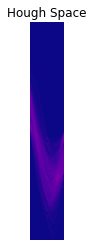

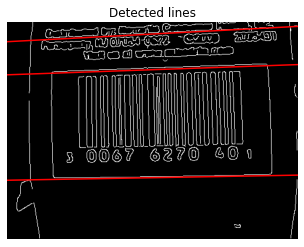

In [27]:
#Image 3
image = imgs[2]

edge = feature.canny(image,sigma=2)

plt.imshow(edge,cmap='gray')
plt.title("Canny Edge of image")
plt.axis("off")
plt.show()

h, theta, d = skt.hough_line(edge)
plt.title("Hough Space")
plt.axis("off")
plt.imshow(h,cmap='plasma')
plt.show()

plt.imshow(edge, cmap='gray')
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*skt.hough_line_peaks(h, theta, d,min_distance=35,min_angle=60)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title('Detected lines')
plt.show()

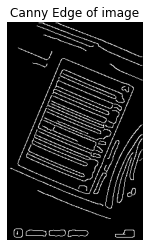

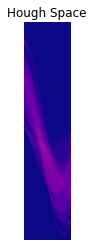

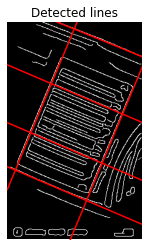

In [28]:
#Image 4
image = imgs[3]

edge = feature.canny(image,sigma=2.5)

plt.imshow(edge,cmap='gray')
plt.title("Canny Edge of image")
plt.axis("off")
plt.show()

h, theta, d = skt.hough_line(edge)
plt.title("Hough Space")
plt.axis("off")
plt.imshow(h,cmap='plasma')
plt.show()

plt.imshow(edge, cmap='gray')
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*skt.hough_line_peaks(h, theta, d,min_distance=35,min_angle=60)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title('Detected lines')
plt.show()

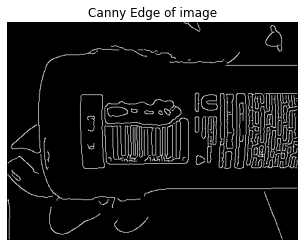

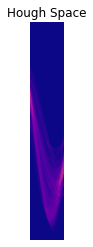

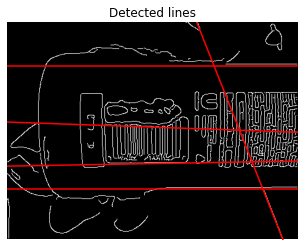

In [29]:
#Image 5
image = imgs[4]

edge = feature.canny(image,sigma=2)

plt.imshow(edge,cmap='gray')
plt.title("Canny Edge of image")
plt.axis("off")
plt.show()

h, theta, d = skt.hough_line(edge)
plt.title("Hough Space")
plt.axis("off")
plt.imshow(h,cmap='plasma')
plt.show()

plt.imshow(edge, cmap='gray')
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*skt.hough_line_peaks(h, theta, d,min_distance=35,min_angle=60)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title('Detected lines')
plt.show()

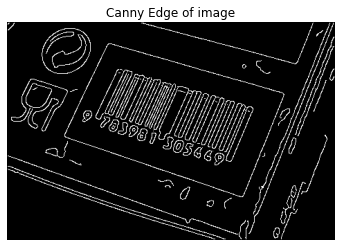

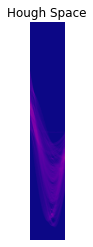

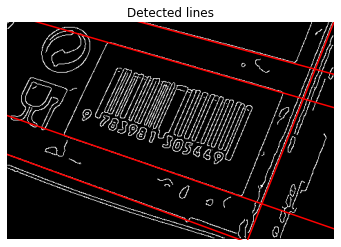

In [30]:
#Image 6
image = imgs[5]

edge = feature.canny(image,sigma=2)

plt.imshow(edge,cmap='gray')
plt.title("Canny Edge of image")
plt.axis("off")
plt.show()

h, theta, d = skt.hough_line(edge)
plt.title("Hough Space")
plt.axis("off")
plt.imshow(h,cmap='plasma')
plt.show()

plt.imshow(edge, cmap='gray')
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*skt.hough_line_peaks(h, theta, d,min_distance=35,min_angle=60)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title('Detected lines')
plt.show()